In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

#### Visualize results of BLAST best hit (genewise) between vertebrate and outgroup species

In [2]:
orthologs_path = '../../dataset/orthologs/'
paralogs_path = '../../dataset/paralogs/'

vert = 'hsa'
outg = 'cin'

orthologs_file = f'{orthologs_path}blast_{outg}_{vert}.best_gene_pairs.tsv'
ortho_df = pd.read_csv(orthologs_file, sep='\t', header=0)
cols = ['vert_gene', 'outg_gene', 'bitscore', 'evalue', 'pident', 'length', 'qcov']
ortho_df.columns = cols
ortho_df.head()

,vert_gene,outg_gene,bitscore,evalue,pident,length,qcov
0,ENSG00000000003,ENSCING00000007815,182.0,7.650000e-58,38.843,242,98
1,ENSG00000000005,ENSCING00000016942,55.8,3.940000e-09,24.085,328,91
2,ENSG00000000419,ENSCING00000003274,396.0,9.490000e-142,76.667,240,92
3,ENSG00000000457,ENSCING00000025138,129.0,2.660000e-31,25.255,392,54
4,ENSG00000000460,ENSCING00000013384,58.2,1.160000e-09,27.397,146,19


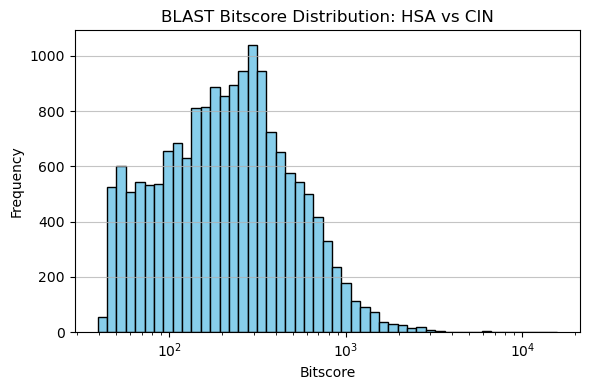

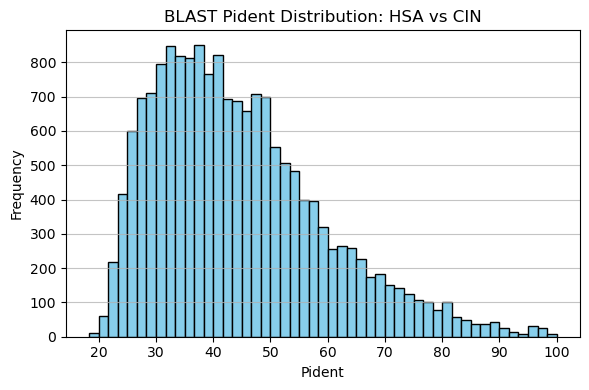

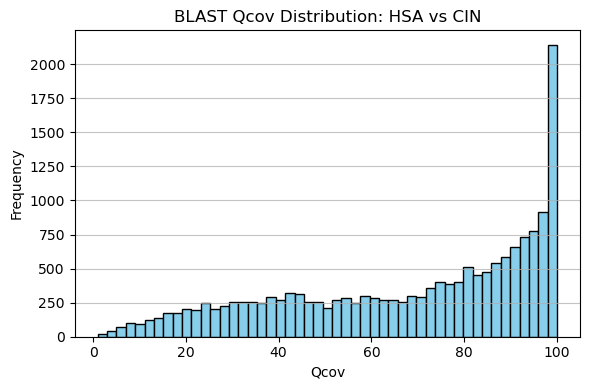

In [3]:
def plotcol(col_str, df, nbins=50, logscale=False):
	plt.figure(figsize=(6,4))
	col = col_str
	min_v = df[col].min()
	max_v = df[col].max()
	if logscale:
		bins = np.logspace(np.log10(min_v), np.log10(max_v), nbins)
	else:
		bins = np.linspace(min_v, max_v, nbins)
	plt.hist(df[col], bins=bins, color='skyblue', edgecolor='black')
	plt.title(f'BLAST {col.capitalize()} Distribution: {vert.upper()} vs {outg.upper()}', fontsize=12)
	plt.xlabel(col.capitalize(), fontsize=10)
	plt.ylabel('Frequency', fontsize=10)
	plt.grid(axis='y', alpha=0.75)
	if logscale:
		plt.xscale('log')
	plt.tight_layout()
	plt.show()

plotcol('bitscore', ortho_df, logscale=True)
plotcol('pident', ortho_df, logscale=False)
plotcol('qcov', ortho_df, logscale=False)

__________________________________________________________

In [4]:
paralogs_file = f'{paralogs_path}{vert}_{outg}.paralogs_from_blast.tsv'
para_df = pd.read_csv(paralogs_file, sep='\t', header=0)
cols = ['vert_gene1', 'vert_gene2', 'outg_gene']
para_df.columns = cols
para_df.head()

,vert_gene1,vert_gene2,outg_gene
0,ENSG00000163867,ENSG00000178567,ENSCING00000000013
1,ENSG00000163867,ENSG00000221909,ENSCING00000000013
2,ENSG00000163867,ENSG00000232040,ENSCING00000000013
3,ENSG00000163867,ENSG00000236287,ENSCING00000000013
4,ENSG00000163867,ENSG00000237765,ENSCING00000000013


____________

In [5]:
G_ortho = nx.Graph()
G_para = nx.Graph()

for index, row in ortho_df.iterrows():
	G_ortho.add_node(row['vert_gene'], bipartite=0)
	G_ortho.add_node(row['outg_gene'], bipartite=1)
	G_ortho.add_edge(row['vert_gene'], row['outg_gene'])

for index, row in para_df.iterrows():
	G_para.add_edge(row['vert_gene1'], row['vert_gene2'])
print(f'Orthologs graph: {G_ortho.number_of_nodes()} nodes, {G_ortho.number_of_edges()} edges')
print(f'Paralogs graph: {G_para.number_of_nodes()} nodes, {G_para.number_of_edges()} edges')

G_ortho_proj = nx.bipartite.projected_graph(G_ortho, nodes=[n for n, d in G_ortho.nodes(data=True) if d['bipartite']==0])
print(f'Projected orthologs graph: {G_ortho_proj.number_of_nodes()} nodes, {G_ortho_proj.number_of_edges()} edges')

Orthologs graph: 23972 nodes, 17030 edges
Paralogs graph: 13429 nodes, 129693 edges
Projected orthologs graph: 17030 nodes, 129693 edges


In [11]:
comp_para_from_ortho = list(nx.connected_components(G_ortho_proj))
comp_para = list(nx.connected_components(G_para))

sizes_para_from_ortho = [len(c) for c in comp_para_from_ortho if len(c) > 1]
sizes_para = [len(c) for c in comp_para]

min_size = min(min(sizes_para_from_ortho), min(sizes_para))
max_size = max(max(sizes_para_from_ortho), max(sizes_para))

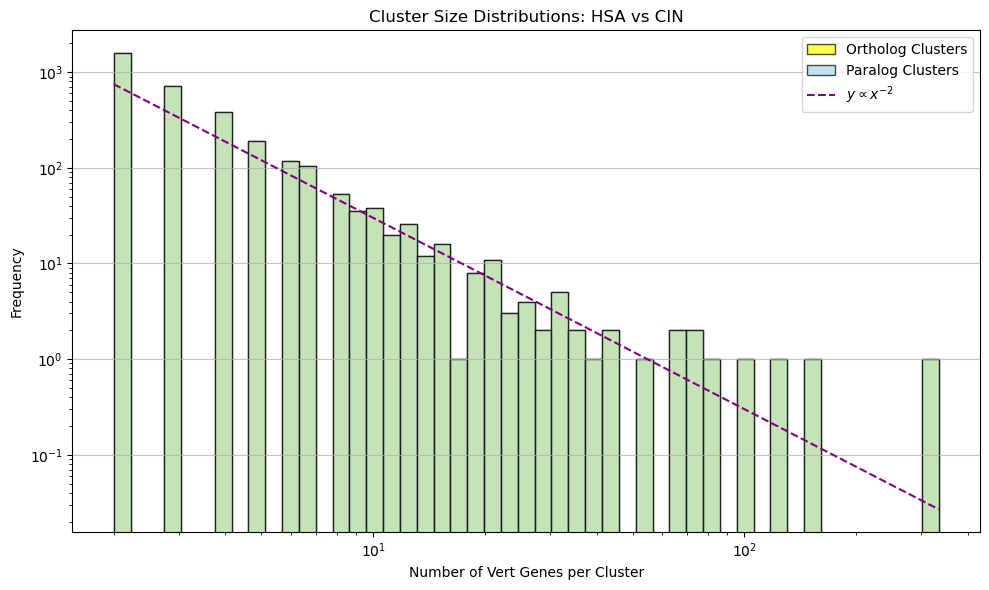

In [12]:
# print the two distributions together to see if they overlap
plt.figure(figsize=(10,6))

bins = np.logspace(np.log10(min_size), np.log10(max_size), 50)
plt.hist(sizes_para_from_ortho, bins=bins, color='yellow', edgecolor='black', alpha=0.7, label='Ortholog Clusters')
plt.hist(sizes_para, bins=bins, color='lightblue', edgecolor='black', alpha=0.7, label='Paralog Clusters')
plt.title(f'Cluster Size Distributions: {vert.upper()} vs {outg.upper()}', fontsize=12)
plt.xlabel('Number of Vert Genes per Cluster', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
x = np.array(bins)
y = 3000 * x**-2
plt.plot(x, y, color='purple', linestyle='--', label='$y \propto x^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.tight_layout()
plt.show()